# Capacitance matrix and LOM analysis
### Prerequisite
You need to have a working local installation of Ansys.

## 1. Create the design in Metal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [4]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### In this example, the design consists of 4 qubits and 4 CPWs

In [5]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        bus1 = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        bus2 = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'bus2', 'Q2', 'bus1', '6.0 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'bus1', 'Q2', 'bus2', '6.1 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'bus2', 'Q4', 'bus1', '6.0 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'bus1', 'Q4', 'bus2', '6.1 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

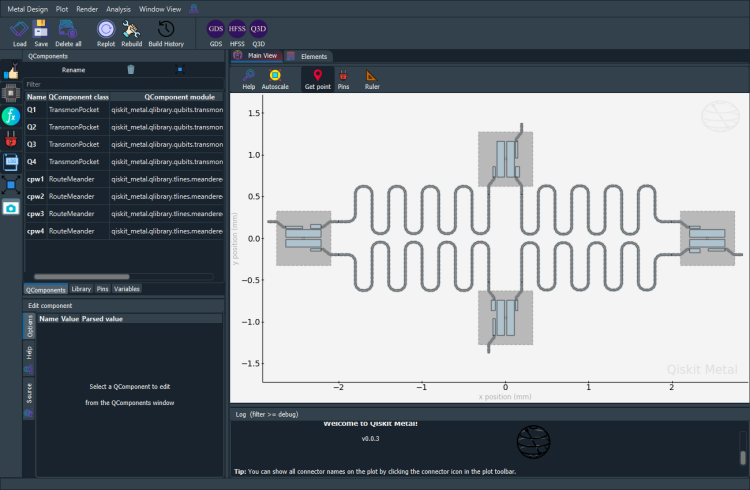

In [6]:
gui.screenshot()

## 2. Capacitance Analysis and LOM derivation using the analysis package - most users

### Capacitance Analysis
Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation

In [7]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

(optional) You can review and update the Analysis default setup following the examples in the next two cells.

In [8]:
c1.setup.sim

{'name': 'Setup',
 'reuse_selected_design': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [9]:
# example: update single setting
c1.setup.sim.max_passes = 6
# example: update multiple settings
c1.setup_update('sim', solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.setup.sim

{'name': 'Setup',
 'reuse_selected_design': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 6,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

Analyze a single qubit with 2 endcaps using the default (or edited) analysis setup. Then show the capacitance matrix (from the last pass).

You can use the method `run()` instead of `run_sim()` in the following cell if you want to run both cap extraction and lom analysis in a single step. If so, make sure to also tweak the setup for the lom analysis. The input parameters are otherwise the same for the two methods. 

In [10]:
c1.run_sim(components=['Q1'], open_terminations=[('Q1', 'readout'), ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.capacitance_matrix

INFO 02:59PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:59PM [load_ansys_project]: 	Opened Ansys App
INFO 02:59PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:59PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project17
INFO 02:59PM [connect_design]: No active design found (or error getting active design).
INFO 02:59PM [connect]: 	 Connected to project "Project17". No design detected
INFO 02:59PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 02:59PM [connect_setup]: 	No design setup detected.
WARNING 02:59PM [connect_setup]: 	Creating Q3D default setup.
INFO 02:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:59PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:59PM [analyze]: Analyzing setup Setup1
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpex7mkrog.txt, C, , Setup1:LastAdaptive,

,bus1_connector_pad_Q1,bus2_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus1_connector_pad_Q1,49.77795,-0.42560,-33.50862,-1.57029,-13.15538,-0.20494
bus2_connector_pad_Q1,-0.42560,54.01886,-35.77522,-13.99741,-1.82852,-1.01319
ground_main_plane,-33.50862,-35.77522,237.69032,-31.53482,-37.88743,-36.55732
pad_bot_Q1,-1.57029,-13.99741,-31.53482,98.20668,-30.07382,-18.86490
pad_top_Q1,-13.15538,-1.82852,-37.88743,-30.07382,87.85076,-2.20122
readout_connector_pad_Q1,-0.20494,-1.01319,-36.55732,-18.86490,-2.20122,59.92345


The last variables you pass to the `run()` or `run_sim()` methods, will be stored in the `setup` dictionary under the key `run`. You can recall the information passed by either accessing the dictionary directly, or by using the print handle below.

In [11]:
# c1.setup.run    <- direct access
c1.print_run_args()

This analysis object run with the following kwargs:
{'name': None, 'components': ['Q1'], 'open_terminations': [('Q1', 'readout'), ('Q1', 'bus1'), ('Q1', 'bus2')], 'box_plus_buffer': True}



You can re-run the analysis after varying the parameters.<br>
Not passing the parameter `components` to the run() method, skips the rendering and tries to run the analysis on the latest design. If a design is not found, the full metal design is rendered.

In [12]:
c1.setup.sim.freq_ghz = 4.8
c1.run_sim()
c1.capacitance_matrix

INFO 03:00PM [get_setup]: 	Opened setup `Setup2`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:00PM [analyze]: Analyzing setup Setup2
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmphnvvskj2.txt, C, , Setup2:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpbzb74ibp.txt, C, , Setup2:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpqvj_z5m6.txt, C, , Setup2:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 2, False
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp8xle02g_.txt, C, , Setup2:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 3, False
INFO 03:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpr3gfhnc2.txt, C, , Setup2:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 4, False


,bus1_connector_pad_Q1,bus2_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus1_connector_pad_Q1,49.77795,-0.42560,-33.50862,-1.57029,-13.15538,-0.20494
bus2_connector_pad_Q1,-0.42560,54.01886,-35.77522,-13.99741,-1.82852,-1.01319
ground_main_plane,-33.50862,-35.77522,237.69032,-31.53482,-37.88743,-36.55732
pad_bot_Q1,-1.57029,-13.99741,-31.53482,98.20668,-30.07382,-18.86490
pad_top_Q1,-13.15538,-1.82852,-37.88743,-30.07382,87.85076,-2.20122
readout_connector_pad_Q1,-0.20494,-1.01319,-36.55732,-18.86490,-2.20122,59.92345


In [13]:
type(c1.capacitance_matrix)

pandas.core.frame.DataFrame

### Lumped oscillator model (LOM)

Using capacitance matrices obtained from each pass, save the many parameters of the Hamiltonian of the system. `get_lumped_oscillator()` operates on 4 setup parameters: <br><br>
Lj: float <br>
Cj: float <br>
fr: Union[list, float] <br>
fb: Union[list, float] <br>

In [14]:
c1.setup.lom.junctions = Dict({'Lj': 12.31, 'Cj': 2})
c1.setup.lom.freq_readout = 7.0
c1.setup.lom.freq_bus = [6.0, 6.2]

c1.run_lom()
c1.lumped_oscillator_all

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.424935 [GHz]
EC 311.976961 [MHz]
EJ 13.273404 [GHz]
alpha -363.792422 [MHz]
dispersion 46.550371 [KHz]
Lq 12.305036 [nH]
Cq 62.088649 [fF]
T1 35.336743 [us]

**Coupling Properties**

tCqbus1 7.383754 [fF]
gbus1_in_MHz 114.265859 [MHz]
χ_bus1 -3.174195 [MHz]
1/T1bus1 2809.281079 [Hz]
T1bus1 56.653264 [us]

tCqbus2 -6.455278 [fF]
gbus2_in_MHz -85.831764 [MHz]
χ_bus2 -9.970461 [MHz]
1/T1bus2 1205.468409 [Hz]
T1bus2 132.027469 [us]

tCqbus3 5.372195 [fF]
gbus3_in_MHz 73.765223 [MHz]
χ_bus3 -4.515423 [MHz]
1/T1bus3 489.201018 [Hz]
T1bus3 325.336492 [us]
Bus-Bus Couplings
gbus1_2 7.097124 [MHz]
gbus1_3 9.957496 [MHz]
gbus2_3 5.377146 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.748489,353.281607,13.273404,-417.442109,135.370296,"[108.79945876100257, -73.5273117232797, 76.416...","[-4.79438808197074, -26.860807586910493, -12.4...",4.794388,108.799459
2,5.664673,342.29546,13.273404,-403.045756,103.898361,"[112.4840344536537, -82.16155872148896, 68.802...","[-4.459428523664997, -22.018842640954155, -7.6...",4.459429,112.484034
3,5.574019,330.63948,13.273404,-387.872659,77.330574,"[111.33611372281577, -84.09225658015613, 71.77...","[-3.7804624736535732, -15.865569463014015, -6....",3.780462,111.336114
4,5.523032,324.186345,13.273404,-379.516614,65.212148,"[110.99788559243069, -84.10822855805147, 72.87...","[-3.4720702173329947, -13.185853760782875, -5....",3.472070,110.997886
5,5.463772,316.778401,13.273404,-369.962797,53.275353,"[113.07908173989175, -84.87717948716897, 72.79...","[-3.293722120335251, -11.011780127871493, -4.8...",3.293722,113.079082
6,5.424935,311.976961,13.273404,-363.792422,46.550371,"[114.26585938574706, -85.83176373490069, 73.76...","[-3.174194994431758, -9.970460698602881, -4.51...",3.174195,114.265859


In [15]:
c1.plot_convergence();
c1.plot_convergence_chi()

Design "Design_q3d" info:
	# eigenmodes    0
	# variations    1


INFO 03:00PM [hfss_report_full_convergence]: Creating report for variation 0


Once you are done with your analysis, please close it with `close()`. This will free up resources currently occupied by qiskit-metal to communiate with the tool.

In [16]:
c1.close()

## 3. Directly access the renderer to modify other parameters

In [17]:
c1.start()
c1.renderer

INFO 03:00PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:00PM [load_ansys_project]: 	Opened Ansys App
INFO 03:00PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:00PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project17
INFO 03:00PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:00PM [connect]: 	Connected to project "Project17" and design "Design_q3d" 😀 



Every renderer will have its own collection of methods. Below an example with q3d

##### Prepare and run a collection of predefined setups

This is equivalent to going to the Project Manager panel in Ansys, right clicking on Analysis within the active Q3D design, selecting "Add Solution Setup...", and choosing/entering default values in the resulting popup window. You might want to do this to keep track of different solution setups, giving each of them a different/specific name.

In [18]:
setup = c1.renderer.new_ansys_setup(name = "Setup_demo", max_passes = 6)

You can directly pass to `new_ansys_setup` all the setup parameters. Of course you will then need to run the individual setups by name as well.

In [19]:
c1.renderer.analyze_setup(setup.name)

INFO 03:00PM [get_setup]: 	Opened setup `Setup_demo`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:00PM [analyze]: Analyzing setup Setup_demo


##### Get the capactiance matrix at a different pass

You might want to use this if you intend to know what was the matrix at a different pass of the simulation.

In [20]:
# Using the analysis results, get its capacitance matrix as a dataframe.
c1.renderer.get_capacitance_matrix(variation = '', solution_kind = 'AdaptivePass', pass_number = 5)

INFO 03:01PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp1hdng5aq.txt, C, , Setup_demo:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 5, False


(                          bus1_connector_pad_Q1  bus2_connector_pad_Q1  \
 bus1_connector_pad_Q1                  48.92803               -0.42235   
 bus2_connector_pad_Q1                  -0.42235               53.06961   
 ground_main_plane                     -33.01607              -35.14374   
 pad_bot_Q1                             -1.53861              -13.67515   
 pad_top_Q1                            -12.84517               -1.81368   
 readout_connector_pad_Q1               -0.20677               -0.99928   
 
                           ground_main_plane  pad_bot_Q1  pad_top_Q1  \
 bus1_connector_pad_Q1             -33.01607    -1.53861   -12.84517   
 bus2_connector_pad_Q1             -35.14374   -13.67515    -1.81368   
 ground_main_plane                 234.01567   -31.50558   -37.64437   
 pad_bot_Q1                        -31.50558    96.95568   -29.44070   
 pad_top_Q1                        -37.64437   -29.44070    86.62922   
 readout_connector_pad_Q1          -36.15

### Code to swap rows and columns in capacitance matrix
from qiskit_metal.analyses.quantization.lumped_capacitive import df_reorder_matrix_basis

df_reorder_matrix_basis(fourq_q3d.get_capacitance_matrix(), 1, 2)

##### Close the renderer

In [21]:
c1.close()